# Project : ```House Price Prediction```

# ```Step-1``` : <i>Library<i>

In [1]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
import re


# ```Step-2``` : <i>Load Dataset<i> And <i>Clean<i>

In [2]:
house_data = pd.read_csv('HousePrice-new.csv')
house_data = house_data.drop(axis=1, labels='Price')
house_data = house_data.dropna()
cols_bool = ['Parking', 'Warehouse', 'Elevator']
house_data[cols_bool] = house_data[cols_bool].astype(int)

# ```Step-3``` : <i>Visualization<i>

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3242 entries, 0 to 3264
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3242 non-null   int64  
 1   Room        3242 non-null   int64  
 2   Parking     3242 non-null   int32  
 3   Warehouse   3242 non-null   int32  
 4   Elevator    3242 non-null   int32  
 5   Address     3242 non-null   object 
 6   Price(USD)  3242 non-null   float64
dtypes: float64(1), int32(3), int64(2), object(1)
memory usage: 164.6+ KB


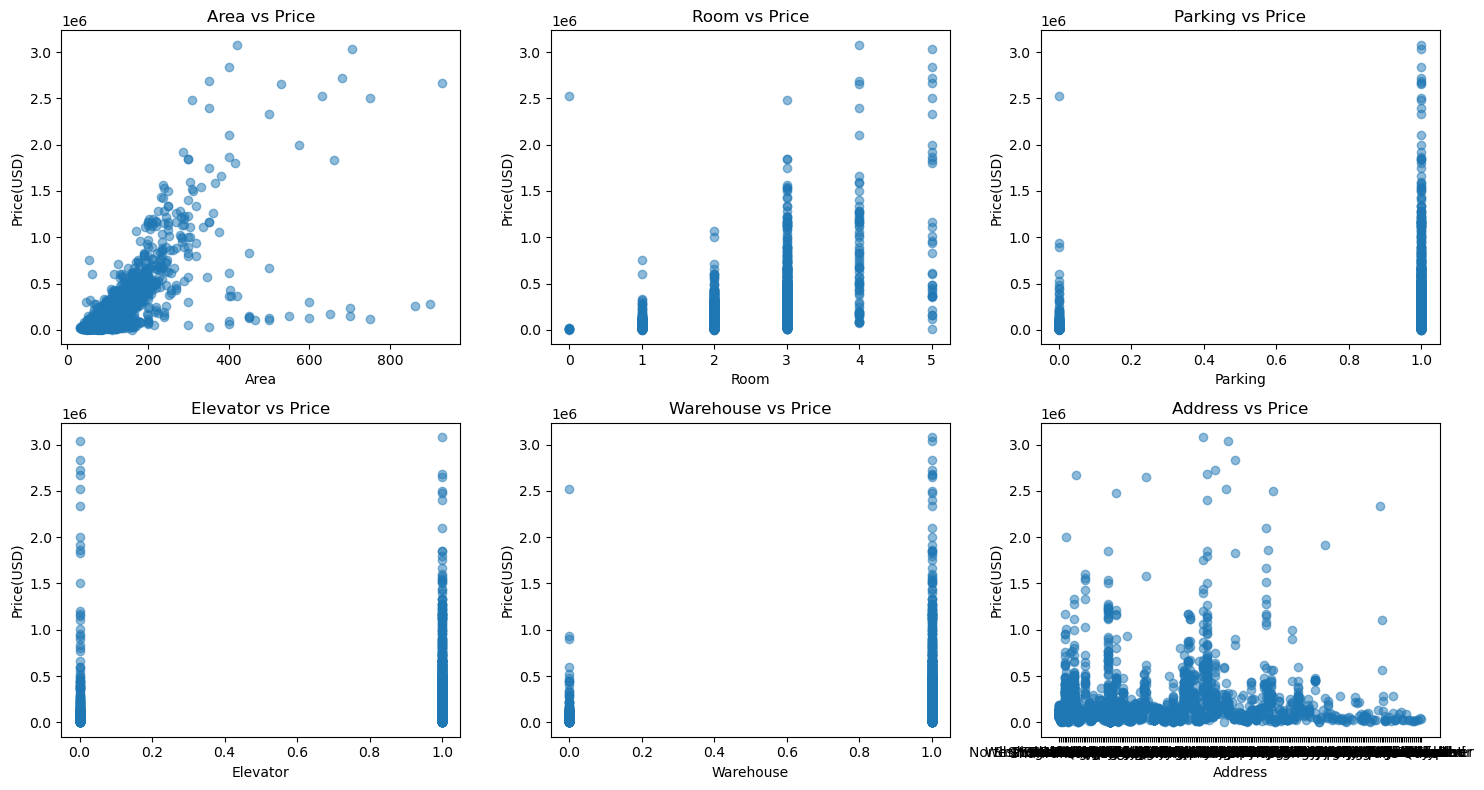

In [4]:

features = ['Area', 'Room', 'Parking', 'Elevator', 'Warehouse', 'Address']  

n = len(features)
cols = 3  
rows = (n + cols - 1) // cols  

plt.figure(figsize=(cols * 5, rows * 4)) 

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    plt.scatter(house_data[feature], house_data['Price(USD)'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Price(USD)')
    plt.title(f'{feature} vs Price')

plt.tight_layout()
plt.show()


# ```Step-4``` : <i>Encoding<i> And <i>Delete Outlier's<i>

In [5]:
# Encode Address
mean_price_by_address = house_data.groupby('Address')['Price(USD)'].mean()
house_data.loc[:, 'Address'] = house_data['Address'].map(mean_price_by_address)

initial_count = len(house_data)

# Delete Outlier Data from : Price, Area
numeric_cols = ['Price(USD)']
z_scores = np.abs(zscore(house_data[numeric_cols]))
filtered_entries = (z_scores < 1.9).all(axis=1) # 1.9
house_data = house_data[filtered_entries].reset_index(drop=True)

#Report
removed_count = initial_count - len(house_data)
removed_percentage = (removed_count / initial_count) * 100
print("\n Outlier Removal Report:")
print(f"- Number of data points before removal: {initial_count}")
print(f"- Number of data points removed: {removed_count}")
print(f"- Percentage of data points removed: {removed_percentage:.2f}%")
print(f"- Number of data points remaining: {len(house_data)}")

# Prepare Data for Scaling and Learning model
X = house_data[['Area', 'Room', 'Parking', 'Elevator', 'Warehouse', 'Address']]
y = house_data['Price(USD)']



 Outlier Removal Report:
- Number of data points before removal: 3242
- Number of data points removed: 123
- Percentage of data points removed: 3.79%
- Number of data points remaining: 3119


# ```Step-4.1``` : <i>Split Data<i>

In [6]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ```Step-5.1``` : <i>Decision Tree<i>

Decision Tree R² Score: 0.8494391401367554
Decision Tree MSE: 2748649832.6803865
Decision Tree RMSE: 52427.57


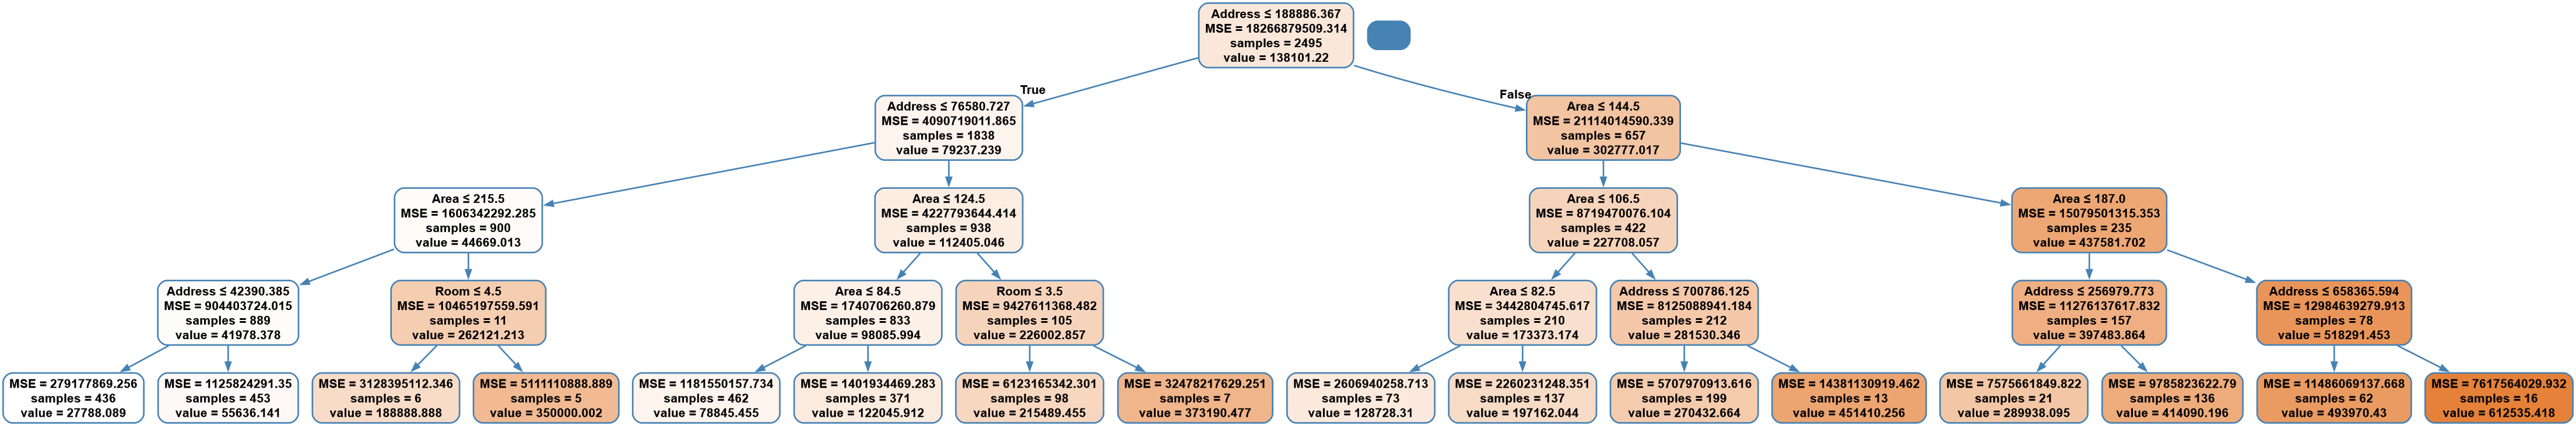

In [7]:
# Train Decision Tree 
model = DecisionTreeRegressor(random_state=42, max_depth=4) 
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Decision Tree R² Score: {r2_score(y_test, y_pred)}")
print(f"Decision Tree MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Decision Tree RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


# export as dot file
dot_data = export_graphviz(
    model,
    out_file=None,  
    feature_names=X_train.columns,  
    filled=True,
    rounded=True,
    special_characters=True,
    label='all',fontname='Arial Bold'
)
dot_data = re.sub(r'squared_error', 'MSE', dot_data)

# convert to image using pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)
for node in graph.get_nodes():
    node.set_fontsize(16)            
    node.set_color("#4682B4")       
    node.set_penwidth(2) 
    node.set_shape("box")
    
Image(graph.create_png())




     Feature  Importance
5    Address    0.703139
0       Area    0.290858
1       Room    0.006003
2    Parking    0.000000
3   Elevator    0.000000
4  Warehouse    0.000000


C:\Users\COXICAN\AppData\Local\Temp\ipykernel_18112\3635792607.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


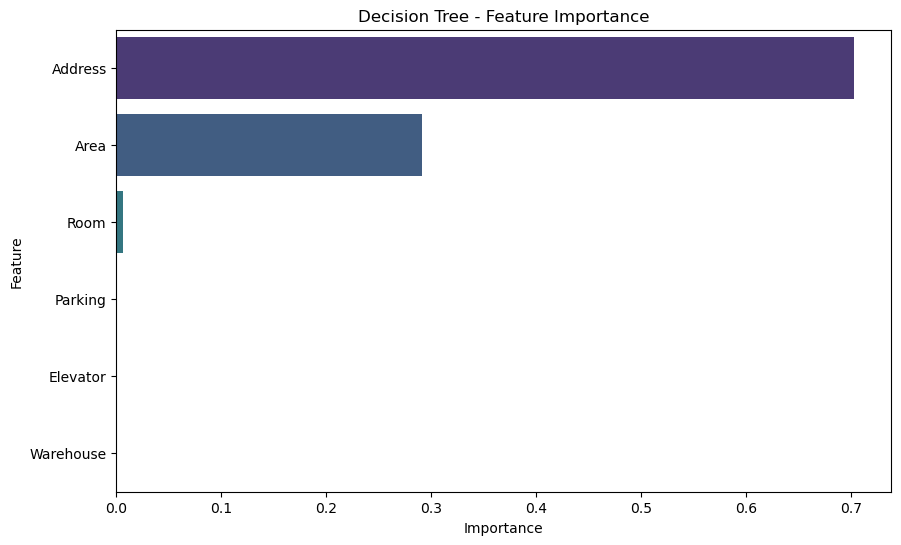

In [8]:
# Feature Imporance
feature_importance = model.feature_importances_

# Convert to Dataframe
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Decision Tree - Feature Importance')
plt.show()


# ```Step-5.2``` : <i>Random Forest<i>


In [9]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=None,        # Maximum depth of each tree
    min_samples_split=2,   # Minimum number of samples required to split a node
    min_samples_leaf=1,    # Minimum number of samples required at each leaf node
    random_state=42,
    n_jobs=-1,             # Use all available cores
    max_leaf_nodes=100
)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")

Random Forest R² Score: 0.8948
Random Forest MSE: 1921261850.88
Random Forest RMSE: 43832.20



Random Forest Feature Importance:
     Feature  Importance
5    Address    0.672389
0       Area    0.305910
1       Room    0.013950
3   Elevator    0.005042
2    Parking    0.001877
4  Warehouse    0.000832


C:\Users\COXICAN\AppData\Local\Temp\ipykernel_18112\2261637064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_rf, palette='viridis')


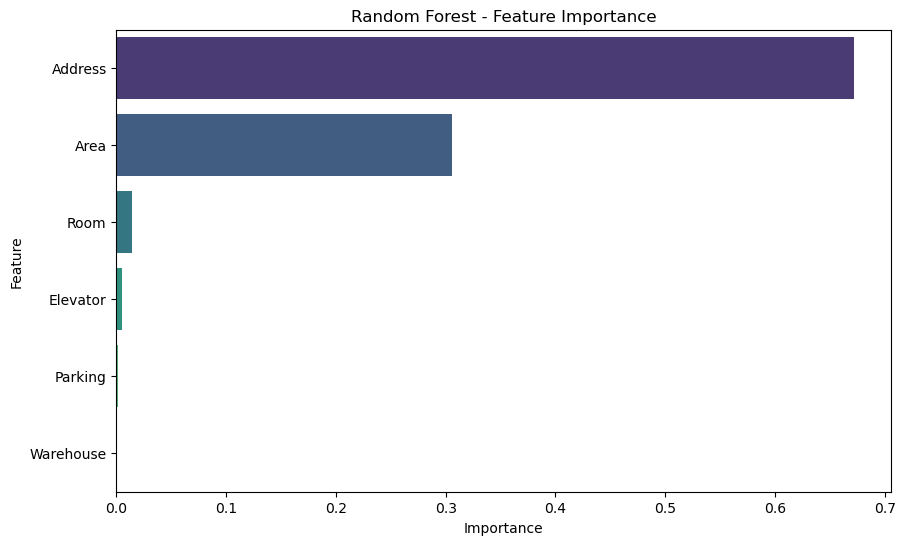

In [10]:
# Feature Importance
rf_feature_importance = rf_model.feature_importances_
importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importance
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(importance_df_rf)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf, palette='viridis')
plt.title('Random Forest - Feature Importance')
plt.show()

# ```Step-5.3``` : <i>SVM (Support Vector Machine)<i> 

In [11]:

# Feature Scaling 
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Train SVM (SVR)
model = SVR(kernel='rbf', C=1.0, epsilon=0.25)  
model.fit(X_train_scaled, y_train_scaled)

# Predict and inverse scaling
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
print(f"SVM R² Score: {r2_score(y_test, y_pred)}")
print(f"SVM MSE: {mean_squared_error(y_test, y_pred)}")
print(f"SVM RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


SVM R² Score: 0.8831305495442904
SVM MSE: 2133577051.3818352
SVM RMSE: 46190.66


     Feature    Importance
0       Area  9.495989e-06
5    Address  8.321158e-06
1       Room  1.532244e-06
2    Parking  1.417536e-06
3   Elevator  7.458720e-07
4  Warehouse  3.238584e-07


C:\Users\COXICAN\AppData\Local\Temp\ipykernel_18112\332075017.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


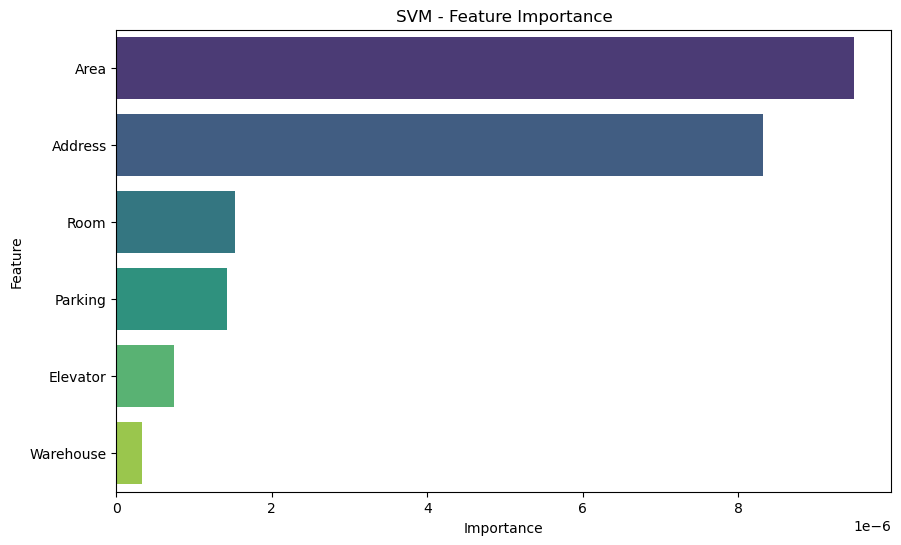

In [12]:
# calculate imporance (its different with rf, dt)
result = permutation_importance(
    model, X_test_scaled, y_test, n_repeats=10, random_state=42
)

# Feature Imporance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('SVM - Feature Importance')
plt.show()

# ```Step-5.4``` : <i>Gradient Descent<i>

In [13]:
# Feature Scaling 
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

model = SGDRegressor(max_iter=3_999_999_999, learning_rate='adaptive', eta0=0.01, random_state=42)
model.fit(X_train_scaled, y_train_scaled)  


# Predict and inverse scaling
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Evaluate
print(f"Gradient Discent R² Score: {r2_score(y_test, y_pred)}")
print(f"Gradient Discent MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Gradient Discent RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


Gradient Discent R² Score: 0.7489222898503014
Gradient Discent MSE: 4583692645.084443
Gradient Discent RMSE: 67702.97


     Feature    Importance
0       Area  9.495989e-06
5    Address  8.321158e-06
1       Room  1.532244e-06
2    Parking  1.417536e-06
3   Elevator  7.458720e-07
4  Warehouse  3.238584e-07


C:\Users\COXICAN\AppData\Local\Temp\ipykernel_18112\1653012201.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


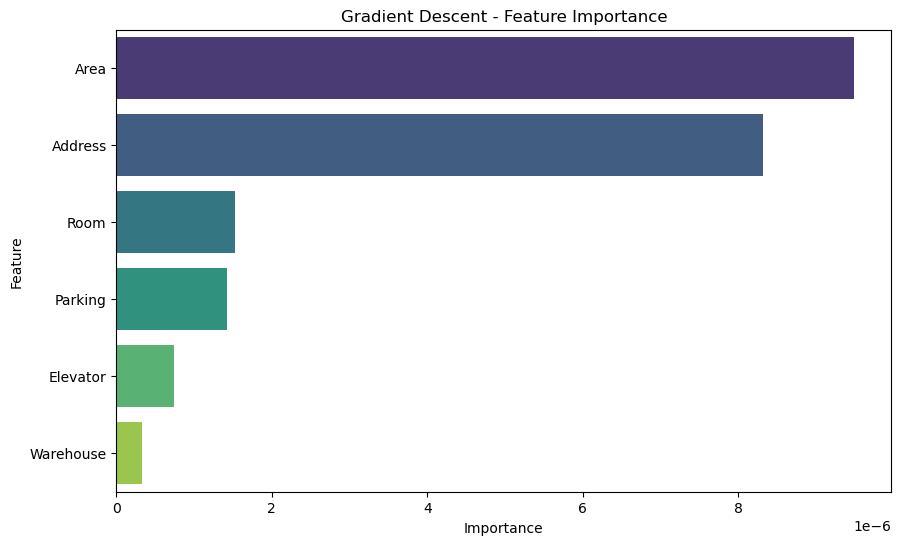

In [14]:
# Feature imporance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Gradient Descent - Feature Importance')
plt.show()